In [1]:
from __future__ import division, print_function, absolute_import
import logging
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import time


from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_valid_land_house_ids, dumpStratifiedBatches_balanced_class
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


images_per_label = None # normally 5000 each label is good
assessor_img_type = 'assessor'
aerial_img_type = 'google_aerial' # 'bing_aerial'
overlayed_img_type = 'google_overlayed'
streetside_img_type = None


image_type = overlayed_img_type

if image_type == 'assessor':
    inp_image_shape = [260, 260, 3]
elif image_type == 'google_aerial':
    inp_image_shape = [400, 400, 3]
elif image_type == 'google_overlayed':
    inp_image_shape = [400, 400, 3]
elif image_type == 'google_streetside':
    inp_image_shape = [260, 260, 3]
else:
    raise ValueError('Not a valid image type provided')
    
which_net = 'convnet'
batch_prepare = True
train = True
test = True

## PREPARE/DUMP BATCHES:

In [ ]:
start_time = time.time()

cmn_land_pins, cmn_house_pins = get_valid_land_house_ids(
        aerial_img_type=aerial_img_type,
        streetside_img_type=streetside_img_type,
        overlayed_img_type=overlayed_img_type,
        images_per_label=images_per_label)
print (len(cmn_land_pins), len(cmn_house_pins))

tr_batch_size = 128
ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10

dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, img_resize_shape=inp_image_shape,
                                     image_type=image_type, ts_batch_size=ts_batch_size, 
                                     cv_batch_size=cv_batch_size, tr_batch_size=tr_batch_size,
                                     shuffle_seed=873, get_stats=True, max_batches=None)
print ('--------------- %s seconds ------------------'%(time.time() - start_time))

C:\Users\newline\Documents\ImageClassification\data\input_images\aerial_images\google\land
aerial pins:  5433 5433
common aerial pins:  5433 5433
C:\Users\newline\Documents\ImageClassification\data\input_images\overlayed_images\google\land
overlayed pins:  5433 5433
common overlayed pins:  5433 5433
5433 5433


# EVALUATE MODELS:
------------

# TRAIN MODEL: Overlayed Images [Central crop: 96 x 96]
------------

## Train  learning_rate = 0.0001
-----------

In [2]:
max_batches = 66
start_time = time.time()
if train:
    tr_obj = Train(dict(learning_rate=0.0001,
                        inp_img_shape=[400, 400, 3],
                        crop_shape=[96, 96, 3],
                        out_img_shape=[96, 96, 3],
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
                   device_type='gpu',
                   which_net='convnet',  # vgg
                   image_type='google_overlayed')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr,
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr) = tr_obj.run(num_epochs=7, num_batches=max_batches, get_stats_at=10)  # + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping Checkpoints to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\checkpoint\convnet
Dumping Tensorboard Summary to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\summary\convnet
Learning Rate: Initial:  0.0001
Checkpoints not found, Hence starting at batch 0 and epoch 0........
----------649.1815226078033 seconds------------


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 0.40332, train_acc = 0.89815, train_precision = 0.905235130497, train_recall = 0.891876352814, cv_loss = 0.459728, cv_acc = 0.877739, cv_precision = 0.882656305916, cv_recall = 0.872214079002


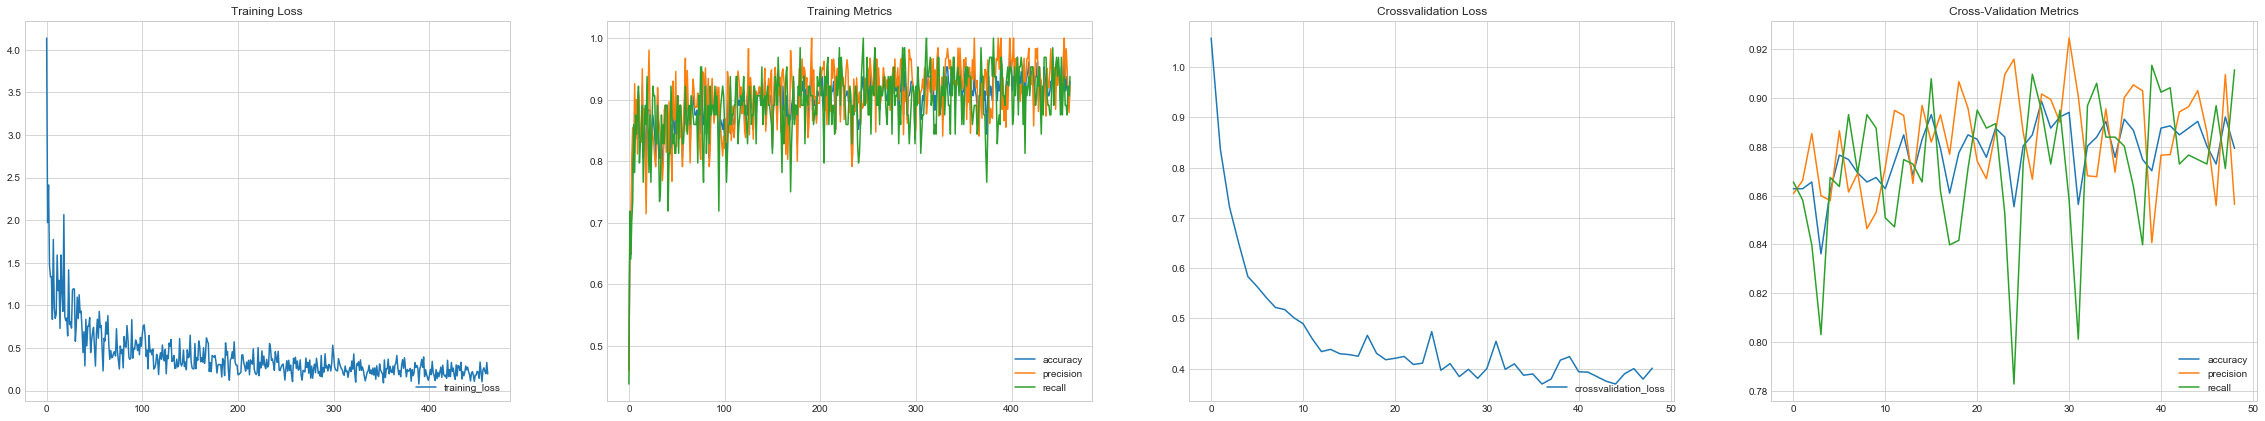

In [4]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

### Cross Validation and Test : learning_rate = 0.0001

In [6]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[96, 96, 3]),
         device_type='gpu',
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\checkpoint\convnet
Dumping Tensorboard Summary to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\summary\convnet
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005


In [7]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[96, 96, 3]),
         device_type='gpu',        
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\checkpoint\convnet
Dumping Tensorboard Summary to %s C:\Users\newline\Documents\ImageClassification\data\data_models\overlayed_images\google\summary\convnet
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005
Test Graphs: CONVNET
Learning Rate: Initial:  0.0005


In [8]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 0.390727, cvalid_acc = 0.883425, cvalid_precision = 0.879571786795, cvalid_recall = 0.889686924494, test_loss = 0.384139, test_acc = 0.884162, test_precision = 0.885693092303, test_recall = 0.883425414365


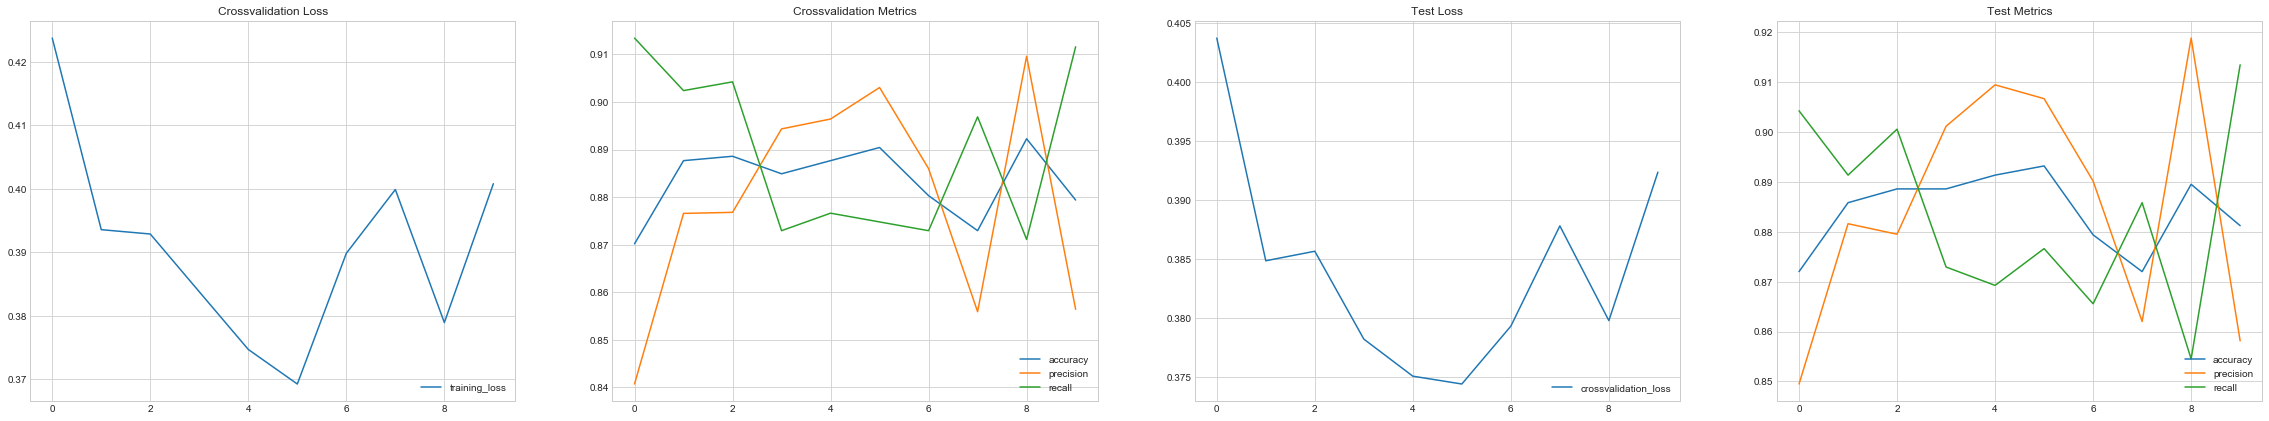

In [9]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})